# Importing necessary libraries and dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
# Load MNIST dataset
train_data = MNIST(root="./data", train=True, download=True, transform=ToTensor())
test_data = MNIST(root="./data", train=False, download=True, transform=ToTensor())

# Data exploration

In [ ]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


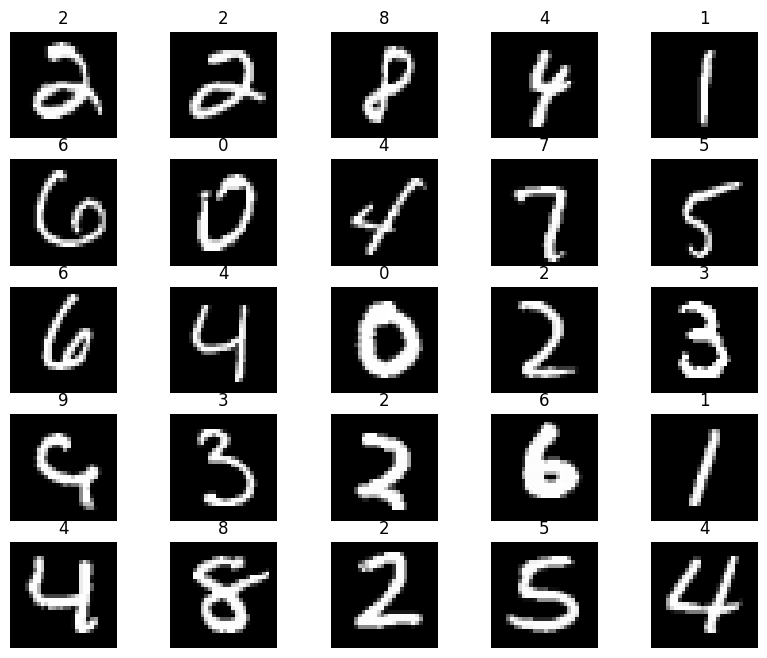

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

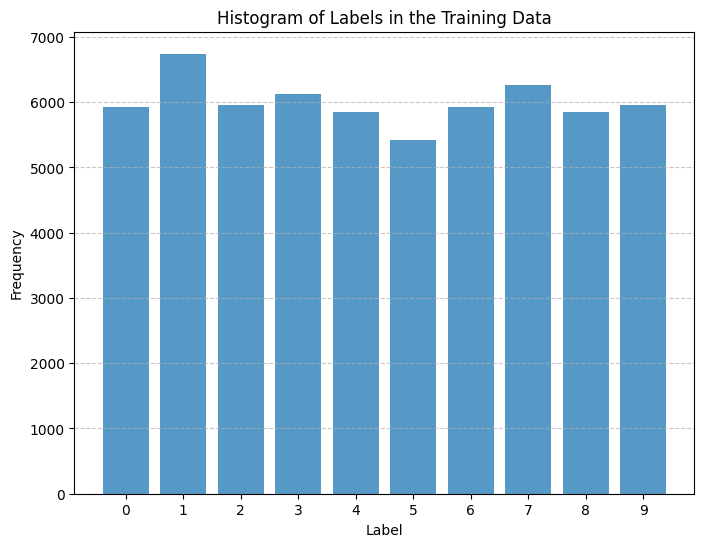

In [ ]:
# Get the labels from the training data
train_labels = [label for _, label in train_data]

# Plot a histogram of the labels
plt.figure(figsize=(8, 6))
plt.hist(train_labels, bins=range(11), rwidth=0.8, align='left', alpha=0.75)
plt.xticks(range(10))
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Histogram of Labels in the Training Data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Data processing

In [ ]:
# Calculate pixel statistics
pixel_values = torch.cat([img.view(-1) for img, _ in train_data], dim=0)
pixel_mean = torch.mean(pixel_values)
pixel_max = torch.max(pixel_values)
pixel_min = torch.min(pixel_values)
pixel_std = torch.std(pixel_values)

# Print statistics
print(f"Pixel mean: {pixel_mean.item()}")
print(f"Pixel max: {pixel_max.item()}")
print(f"Pixel min: {pixel_min.item()}")
print(f"Pixel std: {pixel_std.item()}")

# Visualize pixel value distribution
plt.figure(figsize=(12, 6))

Pixel mean: 0.13066047430038452
Pixel max: 1.0
Pixel min: 0.0
Pixel std: 0.30810782313346863


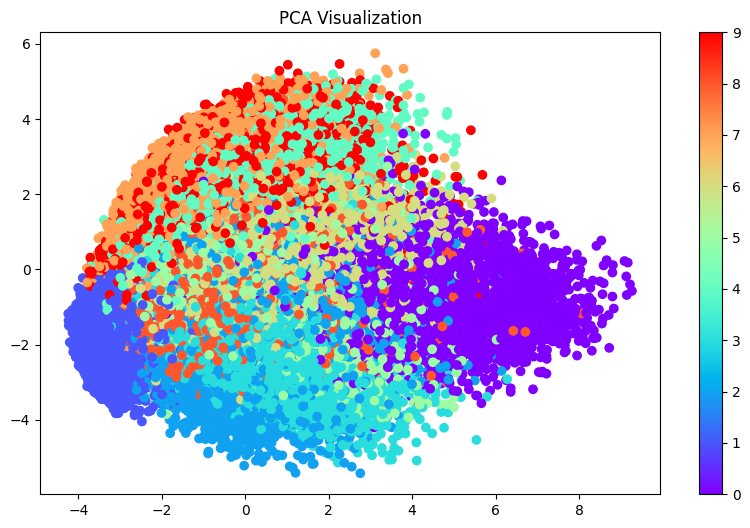

In [ ]:
# Flatten the images for dimensionality reduction
flattened_images = [img.view(-1).numpy() for img, _ in train_data]

pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_images)

plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=train_labels, cmap='rainbow')
plt.title('PCA Visualization')
plt.colorbar()
plt.show()


# CNN:

In [ ]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self, num_filters=32, kernel_size=3, pool_size=2, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size)
        self.pool = nn.MaxPool2d(pool_size)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size)
        self.fc = nn.Linear(num_filters * 5 * 5, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
train_accuracy = []
# Define function to train and evaluate model
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        val_accuracy = 0.0

        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

            val_accuracy = correct / total

        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        train_acc_list.append(train_accuracy)
        val_acc_list.append(val_accuracy)

        print(f"Epoch: {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return train_acc_list, val_acc_list

In [ ]:
# Split data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [ ]:
# Set hyperparameters to be tuned
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30],
}

In [ ]:
# Perform grid search for hyperparameter tuning
best_accuracy = 0.0
best_params = {}

for params in ParameterGrid(param_grid):
    # Create model
    model = CNN()

    # Extract hyperparameters
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train and evaluate the model
    train_acc_list, val_acc_list = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs)
    train_acc = train_acc_list[-1]
    val_acc = val_acc_list[-1]

    # Check if current model is the best
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_params = params

# Print best hyperparameters and accuracy
print('Best Hyperparameters:', best_params)
print('Best Accuracy:', best_accuracy)

Epoch: 1/10, Training Loss: 0.4785, Validation Loss: 0.2076
Epoch: 2/10, Training Loss: 0.1402, Validation Loss: 0.1312
Epoch: 3/10, Training Loss: 0.0990, Validation Loss: 0.1121
Epoch: 4/10, Training Loss: 0.0786, Validation Loss: 0.0988
Epoch: 5/10, Training Loss: 0.0643, Validation Loss: 0.1083
Epoch: 6/10, Training Loss: 0.0542, Validation Loss: 0.0709
Epoch: 7/10, Training Loss: 0.0445, Validation Loss: 0.0874
Epoch: 8/10, Training Loss: 0.0382, Validation Loss: 0.0785
Epoch: 9/10, Training Loss: 0.0333, Validation Loss: 0.0842
Epoch: 10/10, Training Loss: 0.0278, Validation Loss: 0.0763
Epoch: 1/10, Training Loss: 0.5087, Validation Loss: 0.2457
Epoch: 2/10, Training Loss: 0.2110, Validation Loss: 0.2242
Epoch: 3/10, Training Loss: 0.1805, Validation Loss: 0.1782
Epoch: 4/10, Training Loss: 0.1677, Validation Loss: 0.2173
Epoch: 5/10, Training Loss: 0.1657, Validation Loss: 0.2119
Epoch: 6/10, Training Loss: 0.1421, Validation Loss: 0.1667
Epoch: 7/10, Training Loss: 0.1392, Val

In [ ]:
# Set the best hyperparameters
best_hyperparams = {'batch_size': 64, 'epochs': 30, 'learning_rate': 0.001}

# Extract the hyperparameters
learning_rate = best_hyperparams['learning_rate']
batch_size = best_hyperparams['batch_size']
epochs = best_hyperparams['epochs']

# Create data loaders for training and testing
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Create a new instance of the model
model = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_acc_list, _ = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs)

# Calculate and print the final accuracy
test_acc = evaluate(model, test_loader)
print('Final Test Accuracy:', test_acc)


Epoch: 1/30, Training Loss: 0.6333, Validation Loss: 0.2124
Epoch: 2/30, Training Loss: 0.1875, Validation Loss: 0.1244
Epoch: 3/30, Training Loss: 0.1230, Validation Loss: 0.1032
Epoch: 4/30, Training Loss: 0.0982, Validation Loss: 0.1029
Epoch: 5/30, Training Loss: 0.0842, Validation Loss: 0.0753
Epoch: 6/30, Training Loss: 0.0733, Validation Loss: 0.0669
Epoch: 7/30, Training Loss: 0.0648, Validation Loss: 0.0705
Epoch: 8/30, Training Loss: 0.0547, Validation Loss: 0.0659
Epoch: 9/30, Training Loss: 0.0490, Validation Loss: 0.0563
Epoch: 10/30, Training Loss: 0.0456, Validation Loss: 0.0626
Epoch: 11/30, Training Loss: 0.0398, Validation Loss: 0.0662
Epoch: 12/30, Training Loss: 0.0356, Validation Loss: 0.0667
Epoch: 13/30, Training Loss: 0.0321, Validation Loss: 0.0533
Epoch: 14/30, Training Loss: 0.0262, Validation Loss: 0.0674
Epoch: 15/30, Training Loss: 0.0235, Validation Loss: 0.0606
Epoch: 16/30, Training Loss: 0.0201, Validation Loss: 0.0675
Epoch: 17/30, Training Loss: 0.01

In [ ]:
# Save the model weights
torch.save(model.state_dict(), 'model_weights.pth')

# SVM:

Now let's process the data for using it with an SVM which is the second model we want to experiment for the mnist dataset.

# Data processing

In [ ]:
# Flatten the image tensors for SVM
train_images_flattened_svm = train_data.data.reshape(-1, 28 * 28)
train_labels_svm = train_data.targets
# Flatten the test images for SVM
test_images_flattened_svm = test_data.data.reshape(-1, 28 * 28)
test_labels_svm = test_data.targets

In [ ]:
# Normalization
train_images_flattened_svm  = train_images_flattened_svm /255.0
test_images_flattened_svm = test_images_flattened_svm/255.0

print("train_images_flattened_svm:", train_images_flattened_svm .shape)
print("test_data:", test_images_flattened_svm.shape)

train_images_flattened_svm: torch.Size([60000, 784])
test_data: torch.Size([10000, 784])


In [ ]:
# scaling the features
train_images_flattened_svm_scaled = scale(train_images_flattened_svm)
# Scale the test images using the same scaler
test_images_flattened_svm_scaled = scale(test_images_flattened_svm)

We will now split the data, as the MNIST dataset is a large dataset, we only want to use a chunk of it for running several experiments on the model, so will take 20% for training

In [ ]:
# Split the data into training and validation sets for SVM
train_images_svm, val_images_svm, train_labels_svm, val_labels_svm = train_test_split(train_images_flattened_svm_scaled, train_labels_svm, test_size=0.2,train_size=0.2, random_state=10)


Now let's compare the linear and non linear SVM's to see which one we should stick with for training the finalized model

Linear SVM

In [ ]:
# Create an SVM classifier
svm_model = SVC(kernel='linear')

# Train the SVM model
svm_model.fit(train_images_svm, train_labels_svm)

# Predict the labels for validation images
val_predictions_svm = svm_model.predict(val_images_svm)

# Calculate the accuracy of the SVM model on the validation set
val_accuracy_svm = accuracy_score(val_labels_svm, val_predictions_svm)
print('SVM Validation Accuracy:', val_accuracy_svm)

# Predict the labels for test images
test_predictions_svm = svm_model.predict(test_images_flattened_svm_scaled)

# Calculate the accuracy of the SVM model on the test set
test_accuracy_svm = accuracy_score(test_labels_svm, test_predictions_svm)
print('SVM Test Accuracy:', test_accuracy_svm)

SVM Validation Accuracy: 0.9218333333333333
SVM Test Accuracy: 0.9248


non-linear SVM

In [ ]:
# Create an SVM classifier
svm_model = SVC(kernel='rbf')

# Train the SVM model
svm_model.fit(train_images_svm, train_labels_svm)

# Predict the labels for validation images
val_predictions_svm = svm_model.predict(val_images_svm)

# Calculate the accuracy of the SVM model on the validation set
val_accuracy_svm = accuracy_score(val_labels_svm, val_predictions_svm)
print('SVM Validation Accuracy:', val_accuracy_svm)

# Predict the labels for test images
test_predictions_svm = svm_model.predict(test_images_flattened_svm_scaled)

# Calculate the accuracy of the SVM model on the test set
test_accuracy_svm = accuracy_score(test_labels_svm, test_predictions_svm)
print('SVM Test Accuracy:', test_accuracy_svm)

SVM Validation Accuracy: 0.9635
SVM Test Accuracy: 0.9632


The non-Linear SVM has a much higher accuracy in both validation and testing, so we will stick to it for the rest of the experiment, now let's do some hyperparamters tunning and try to find the best hyperparamters combination for training this model.

In [ ]:
# creating a KFold object with 5 splits
folds = KFold(n_splits = 5, shuffle = True, random_state = 10)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [5,10]}]

# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model,
                        param_grid = hyper_params,
                        scoring= 'accuracy',
                        cv = folds,
                        verbose = 1,
                        return_train_score=True)

# fit the model
model_cv.fit(train_images_svm, train_labels_svm)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [5, 10], 'gamma': [0.01, 0.001, 0.0001]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_c

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9489166666666667 corresponding to hyperparameters {'C': 5, 'gamma': 0.001}


We need to split the data once again, as we want to train the model on the full data after doing several experiments to find out which hyperparameters combination is the best to use.

In [ ]:
# Split the data into training and validation sets for the best SVM model
train_images_svm, val_images_svm, train_labels_svm, val_labels_svm = train_test_split(train_images_flattened_svm_scaled, train_labels_svm, test_size=0.2, random_state=10)


In [ ]:
# Train the SVM model with the best hyperparameters
# best_svm_model = SVC(kernel='rbf', C=best_hyperparams['C'], gamma=best_hyperparams['gamma'])
best_svm_model = SVC(kernel='rbf', C=5, gamma=0.001)
best_svm_model.fit(train_images_svm, train_labels_svm)

# Save the best SVM model
joblib.dump(best_svm_model, 'best_svm_model.pkl')

# Predict the labels for validation images using the best model
val_predictions_svm = best_svm_model.predict(val_images_svm)

# Calculate the accuracy of the best SVM model on the validation set
val_accuracy_svm = accuracy_score(val_labels_svm, val_predictions_svm)
print('Best SVM Validation Accuracy:', val_accuracy_svm)

Best SVM Validation Accuracy: 0.969


In [ ]:
# Predict the labels for test images using the best model
test_predictions_svm = best_svm_model.predict(test_images_flattened_svm_scaled)

# Calculate the accuracy of the best SVM model on the test set
test_accuracy_svm = accuracy_score(test_labels_svm, test_predictions_svm)
print('Best SVM Test Accuracy:', test_accuracy_svm)

Best SVM Test Accuracy: 0.9689


# Comparing the two best trained models

In [ ]:
# Load the CNN model
cnn_model = CNN()
cnn_model.load_state_dict(torch.load('model_weights.pth'))
cnn_model.eval()

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=800, out_features=10, bias=True)
)

In [ ]:
# Load the best SVM model
best_svm_model = joblib.load('best_svm_model.pkl')

In [ ]:
# Convert the test images to torch tensors for CNN evaluation
test_images_tensor = torch.tensor(test_images_flattened_svm_scaled, dtype=torch.float32).view(-1, 1, 28, 28)

# Evaluate the CNN model
with torch.no_grad():
    cnn_model_predictions = cnn_model(test_images_tensor)
    _, cnn_predicted_labels = torch.max(cnn_model_predictions, 1)
    cnn_model_probabilities = torch.softmax(cnn_model_predictions, dim=1)

# Convert the predictions to numpy arrays
cnn_predicted_labels = cnn_predicted_labels.numpy()
test_labels_numpy = test_labels_svm.numpy()

# Calculate the accuracy of the CNN model on the test set
cnn_accuracy = accuracy_score(test_labels_numpy, cnn_predicted_labels)
print('CNN Test Accuracy:', cnn_accuracy)

# Calculate the confusion matrix and classification report for the CNN model
cnn_confusion_matrix = confusion_matrix(test_labels_numpy, cnn_predicted_labels)
cnn_classification_report = classification_report(test_labels_numpy, cnn_predicted_labels)


CNN Test Accuracy: 0.9362


In [ ]:
# Evaluate the best SVM model
svm_predicted_labels = best_svm_model.predict(test_images_flattened_svm_scaled)

# Calculate the accuracy of the best SVM model on the test set
svm_accuracy = accuracy_score(test_labels_numpy, svm_predicted_labels)
print('Best SVM Test Accuracy:', svm_accuracy)

# Calculate the confusion matrix and classification report for the best SVM model
svm_confusion_matrix = confusion_matrix(test_labels_numpy, svm_predicted_labels)
svm_classification_report = classification_report(test_labels_numpy, svm_predicted_labels)

Best SVM Test Accuracy: 0.9689


In [ ]:
# Print the results
print("\n---CNN Model---")
print("Test Accuracy:", cnn_accuracy)
print("Confusion Matrix:")
print(cnn_confusion_matrix)
print("Classification Report:")
print(cnn_classification_report)

print("\n---Best SVM Model---")
print("Test Accuracy:", svm_accuracy)
print("Confusion Matrix:")
print(svm_confusion_matrix)
print("Classification Report:")
print(svm_classification_report)


---CNN Model---
Test Accuracy: 0.9362
Confusion Matrix:
[[ 949    0    2    1    5    5   11    1    4    2]
 [   1 1096    6    5   11    1    5    2    8    0]
 [   3    6  984   14    1    0    4   10    9    1]
 [   1    1    6  973    3   10    0   11    4    1]
 [   1    4   18    5  940    0    5    1    4    4]
 [   1    0    2   29    3  832    2    3   16    4]
 [   7   21    1    0   15   45  868    0    1    0]
 [   5    4   38   65    2    0    0  896    5   13]
 [   8    1   10   13   13   13    3    9  900    4]
 [   5    0   11   16   15    8    0    6   24  924]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       980
           1       0.97      0.97      0.97      1135
           2       0.91      0.95      0.93      1032
           3       0.87      0.96      0.91      1010
           4       0.93      0.96      0.94       982
           5       0.91      0.93      0.92       892
          

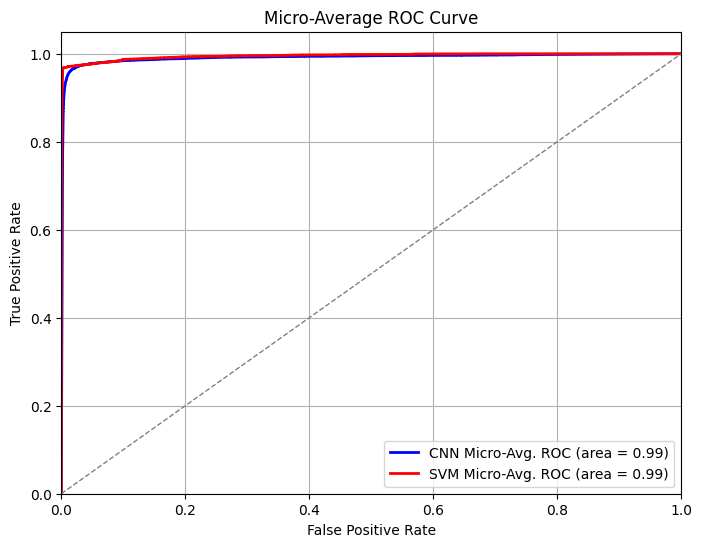

In [ ]:
# Evaluate the SVM model
svm_decision_function = best_svm_model.decision_function(test_images_flattened_svm_scaled)

# Binarize the labels for multiclass classification
test_labels_binarized = label_binarize(test_labels_numpy, classes=range(10))

# Compute the false positive rate and true positive rate for the micro-average ROC curve for the CNN model
fpr_cnn, tpr_cnn, _ = roc_curve(test_labels_binarized.ravel(), cnn_model_probabilities.ravel())

# Compute the false positive rate and true positive rate for the micro-average ROC curve for the SVM model
fpr_svm, tpr_svm, _ = roc_curve(test_labels_binarized.ravel(), svm_decision_function.ravel())

# Compute the area under the curve for the micro-average ROC curve for the CNN and SVM models
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot the micro-average ROC curve for the CNN and SVM models
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, label='CNN Micro-Avg. ROC (area = {:.2f})'.format(roc_auc_cnn))
plt.plot(fpr_svm, tpr_svm, color='red', lw=2, label='SVM Micro-Avg. ROC (area = {:.2f})'.format(roc_auc_svm))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


# Loading saved models and running inference on test set

In [ ]:
# Load the CNN model
class CNN(nn.Module):
    def __init__(self, num_filters=32, kernel_size=3, pool_size=2, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size)
        self.pool = nn.MaxPool2d(pool_size)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size)
        self.fc = nn.Linear(num_filters * 5 * 5, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
cnn_model = CNN()
cnn_model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [ ]:
# Load the best SVM model
best_svm_model = joblib.load('best_svm_model.pkl')

In [ ]:
# Load and process test data
test_data = MNIST(root="./data", train=False, download=True, transform=ToTensor())
test_images_flattened_svm = test_data.data.reshape(-1, 28 * 28)
test_labels_svm = test_data.targets
test_images_flattened_svm = test_images_flattened_svm/255.0
test_images_flattened_svm_scaled = scale(test_images_flattened_svm)

100%|██████████| 9912422/9912422 [00:00<00:00, 105682511.13it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 117951016.38it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24783522.06it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11524820.79it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
# Convert the test images to torch tensors for CNN evaluation
test_images_tensor = torch.tensor(test_images_flattened_svm_scaled, dtype=torch.float32).view(-1, 1, 28, 28)

# Evaluate the CNN model
with torch.no_grad():
    cnn_model_predictions = cnn_model(test_images_tensor)
    _, cnn_predicted_labels = torch.max(cnn_model_predictions, 1)
    cnn_model_probabilities = torch.softmax(cnn_model_predictions, dim=1)

# Convert the predictions to numpy arrays
cnn_predicted_labels = cnn_predicted_labels.numpy()
test_labels_numpy = test_labels_svm.numpy()

# Calculate the accuracy of the CNN model on the test set
cnn_accuracy = accuracy_score(test_labels_numpy, cnn_predicted_labels)
print('CNN Test Accuracy:', cnn_accuracy)

CNN Test Accuracy: 0.9362


In [ ]:
# Evaluate the best SVM model
svm_predicted_labels = best_svm_model.predict(test_images_flattened_svm_scaled)

# Calculate the accuracy of the best SVM model on the test set
svm_accuracy = accuracy_score(test_labels_numpy, svm_predicted_labels)
print('Best SVM Test Accuracy:', svm_accuracy)

Best SVM Test Accuracy: 0.9689


In [ ]:
# Calculate the confusion matrix and classification report for the CNN model
cnn_confusion_matrix = confusion_matrix(test_labels_numpy, cnn_predicted_labels)
# Calculate the confusion matrix and classification report for the best SVM model
svm_confusion_matrix = confusion_matrix(test_labels_numpy, svm_predicted_labels)

In [ ]:
# Print the results
print("\n---CNN Model---")
print("Confusion Matrix:")
print(cnn_confusion_matrix)

print("\n---Best SVM Model---")
print("Confusion Matrix:")
print(svm_confusion_matrix)


---CNN Model---
Confusion Matrix:
[[ 949    0    2    1    5    5   11    1    4    2]
 [   1 1096    6    5   11    1    5    2    8    0]
 [   3    6  984   14    1    0    4   10    9    1]
 [   1    1    6  973    3   10    0   11    4    1]
 [   1    4   18    5  940    0    5    1    4    4]
 [   1    0    2   29    3  832    2    3   16    4]
 [   7   21    1    0   15   45  868    0    1    0]
 [   5    4   38   65    2    0    0  896    5   13]
 [   8    1   10   13   13   13    3    9  900    4]
 [   5    0   11   16   15    8    0    6   24  924]]

---Best SVM Model---
Confusion Matrix:
[[ 968    0    2    1    0    3    3    1    2    0]
 [   0 1128    3    0    0    1    2    0    1    0]
 [   5    2  999    0    2    0    2   13    8    1]
 [   0    0    1  980    1   10    0    9    9    0]
 [   1    0    9    0  951    2    3    7    0    9]
 [   2    1    0   10    2  862    6    4    4    1]
 [   6    2    2    0    3    7  933    2    3    0]
 [   1    8   13    3  

# Building requirements and saving the notebook in html format

In [ ]:
!pip freeze > requirements.txt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!jupyter nbconvert --to html /content/drive/MyDrive/neural_computing/SVM_CNN.ipynb